# Lazy training


Observing the lazy training regime with different models

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import useful functions

# data
from LT_utils import simple_f, middle_f, complex_f, Data, plot_data

# models
from LT_utils import MLPdeep, MLPshallow, plot_net

%load_ext autoreload
%autoreload 2

## The data

We continue with last week's toy problem of 1 dimensional regression

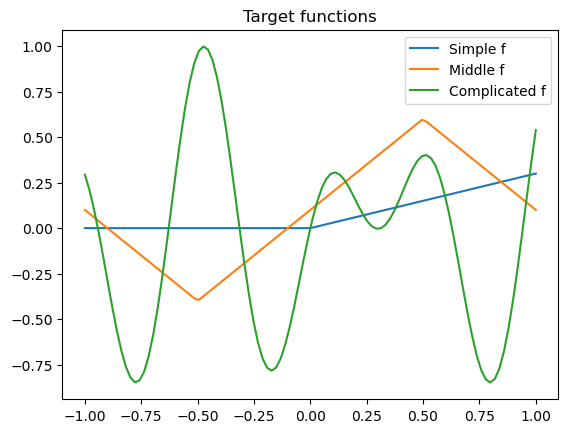

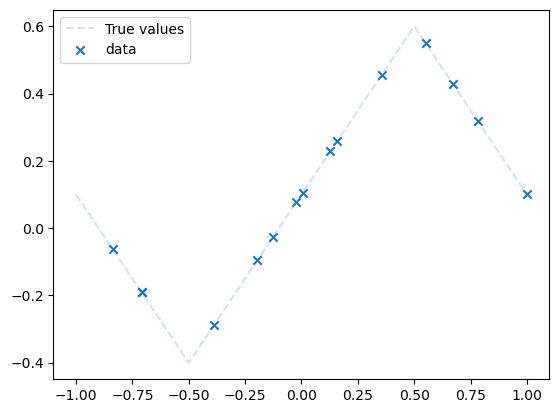

In [4]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, simple_f(xs), label="Simple f")
plt.plot(xs, middle_f(xs), label="Middle f")
plt.plot(xs, complex_f(xs), label="Complicated f")
plt.title("Target functions")
plt.legend()
plt.show()

dataset = Data(n=15, xmin=-1, xmax=1, noise_level=0, type="middle")

plot_data(dataset)
plt.legend()
plt.show()

## The training function

Write the training function

In [7]:
def train(net, dataset, N_steps=1, batch_size=30, lr=0.01, save_weights_every=100):
    optimizer=optim.SGD(net.parameters(), lr=lr)
    criterion=nn.MSELoss()

    losses = []
    weights = []

    for i in range(N_steps):
        
        # sample the data
        x_batch, y_batch = dataset.next_batch(batch_size)
        optimizer.zero_grad()
        y_pred=net(x_batch)
        loss=criterion(y_pred,y_batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())

        if i % save_weights_every == 0 and (save_weights_every > 0):
            with torch.no_grad():
                weights.append(net.save_weights())

    return losses

## Test your training

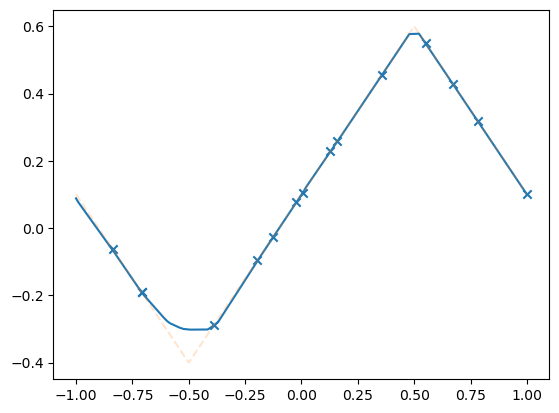

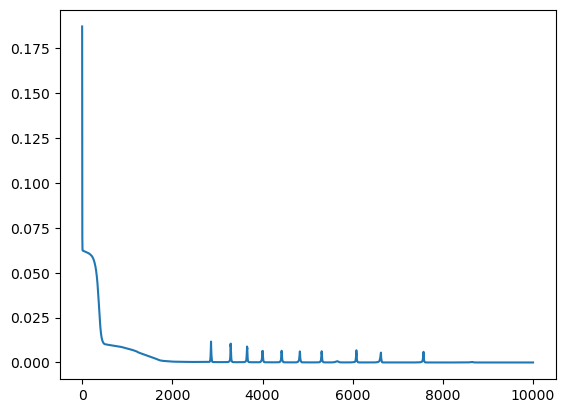

In [8]:
model = MLPdeep(hidden_dim=10)
losses = train(
    model,
    dataset,
    N_steps=10000,
    batch_size=15,
    lr=0.1,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.show()

plt.plot(losses)
plt.show()

# A linear model

We define a family of linear models with sinusoidal features. 
The feature map is 

$$
    \phi(x) = ( \cos(2 \pi x) , \sin(2 \pi x), \cos(4 \pi x) , \sin(4 \pi x), \dots ,  \cos(2k \pi x) , \sin(2k \pi x))
$$
where $k$ is feature_dim / 2. 

In [9]:
class LinSin(nn.Module):
    """
    A linear model with sinusoidal features
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
        Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        k=self.feature_dim//2
        r=2*np.pi*torch.arange(int(self.feature_dim/2))*x

        return torch.concatenate([torch.sin(r), torch.cos(r)], axis=1)

    def save_weights(self):
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x):

        return self.lout(self.phi(x))

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\maloc\AppData\Local\Temp\ipykernel_7004\2424887263.py:14: SyntaxWarning: invalid escape sequence '\p'
  """


Test the linear model

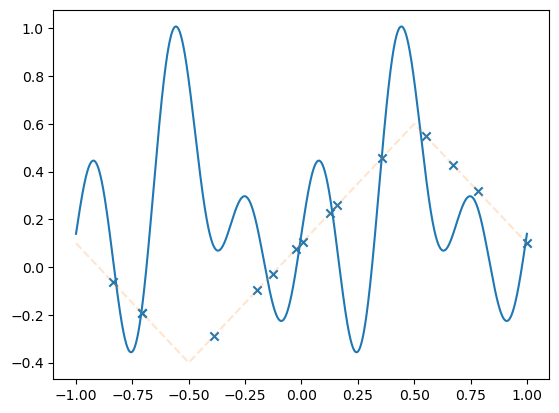

Text(0.5, 1.0, 'Relative weight movement of last layer')

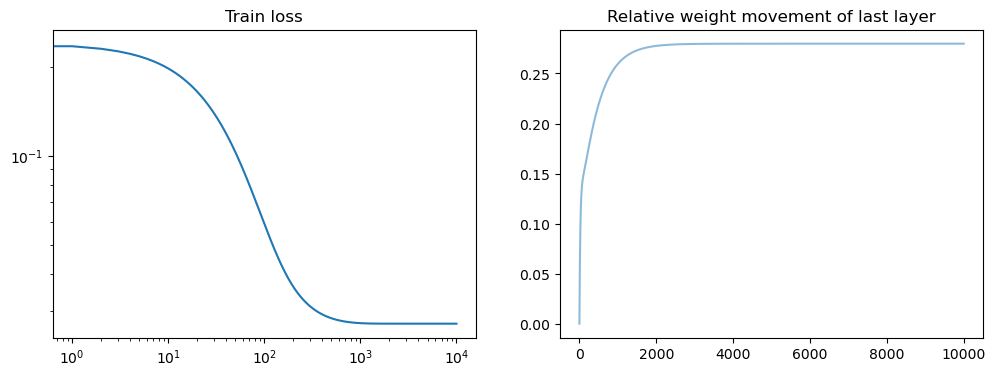

In [10]:
model = LinSin(feature_dim=8)
losses = train(
    model,
    dataset,
    N_steps=10000,
    batch_size=15,
    lr=0.01,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title("Train loss")

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(
    all_weights1[0]
)
axs[1].plot(weight_evol, alpha=0.5)
axs[1].set_title("Relative weight movement of last layer")

**Question**: what do the plots mean?

Let us now repeat the code above with a large feature dimension. What you do observe? 

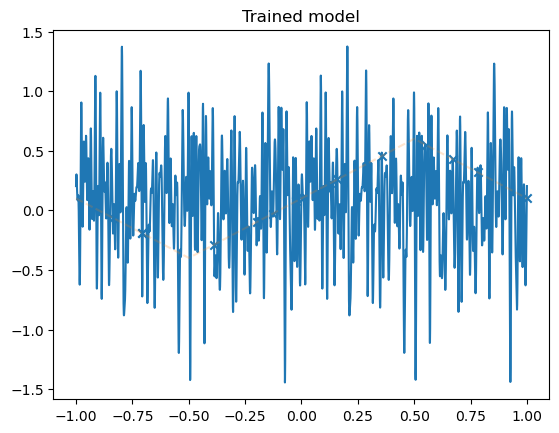

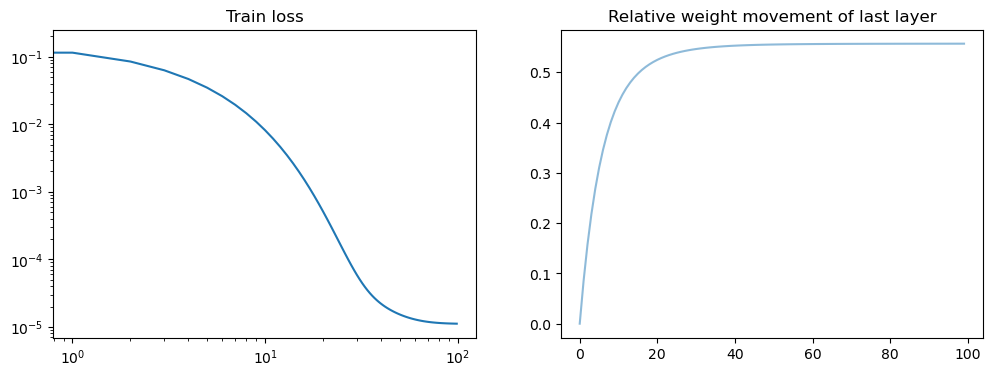

In [11]:
model = LinSin(feature_dim=200)
losses = train(
    model,
    dataset,
    N_steps=100,
    batch_size=15,
    lr=0.01,
    save_weights_every=1,
)

plot_net(model)
plot_data(dataset)
plt.title("Trained model")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title("Train loss")

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(
    all_weights1[0]
)
axs[1].plot(weight_evol, alpha=0.5)
axs[1].set_title("Relative weight movement of last layer")

plt.show()

## Robustness of fast convergence for linear models

Run 10 instances of the linear model with different initializations. 

Are there significant differences between the models? 

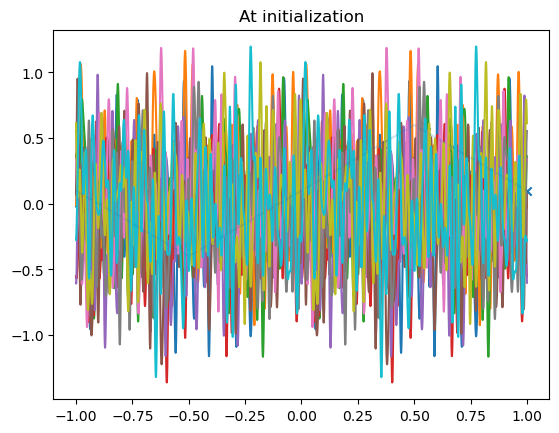

In [12]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = LinSin(feature_dim=100)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title("At initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

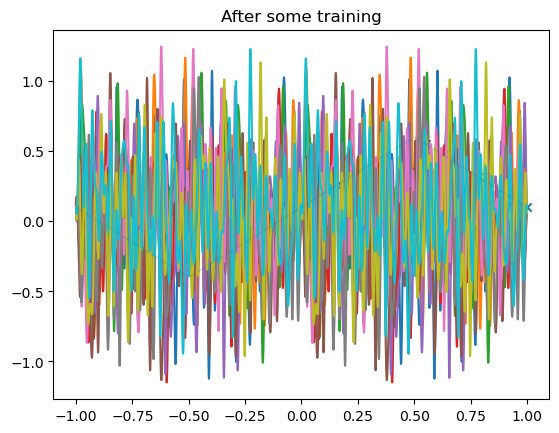

In [13]:
N_steps = 1000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.01,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title("After some training")

plt.show()

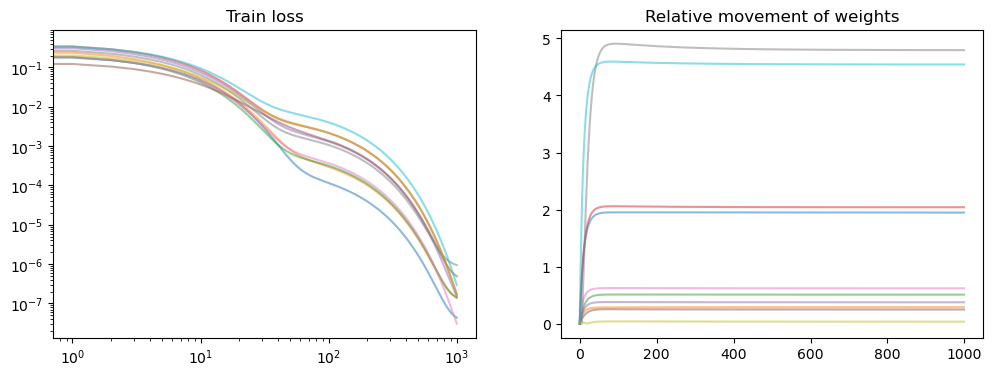

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for losses in all_losses:
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative movement of weights")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

# Lazy training of non-linear models

We now train some neural nets in different regimes and try to see when lazy training occurs. 

**Question** 
How are nets initialized in pytorch?

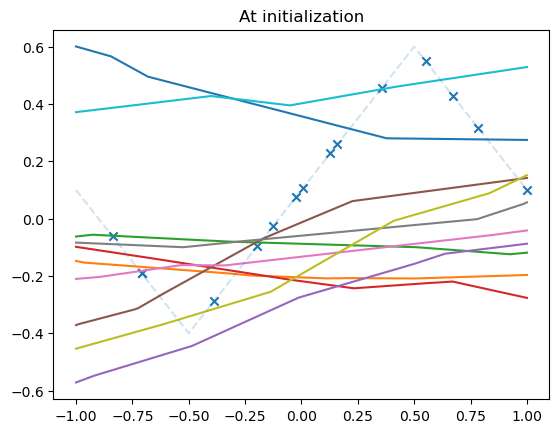

In [15]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = MLPshallow(hidden_dim=10)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title("At initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

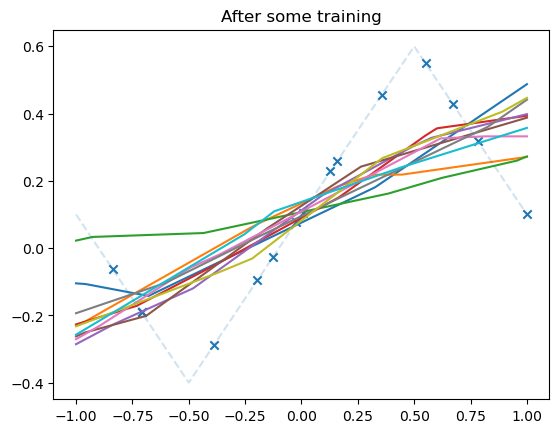

In [16]:
N_steps = 5000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.001,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title("After some training")

plt.show()

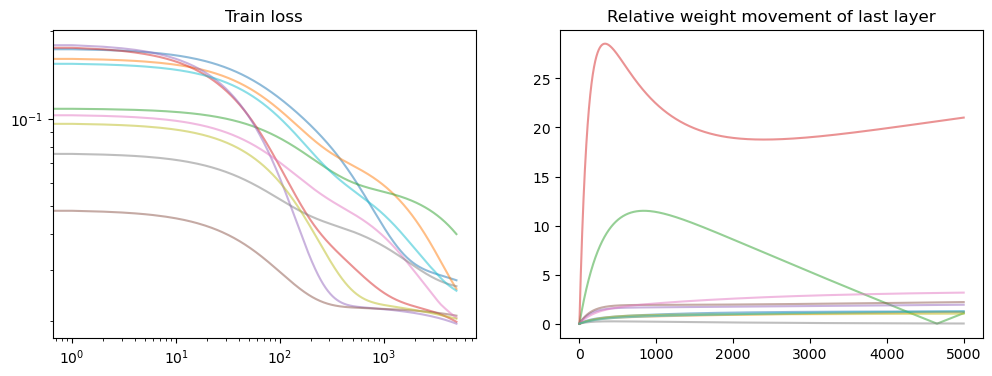

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for losses in all_losses:
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

## Thin vs. Wide networks

Let us now vary the width of our network. What happens? 

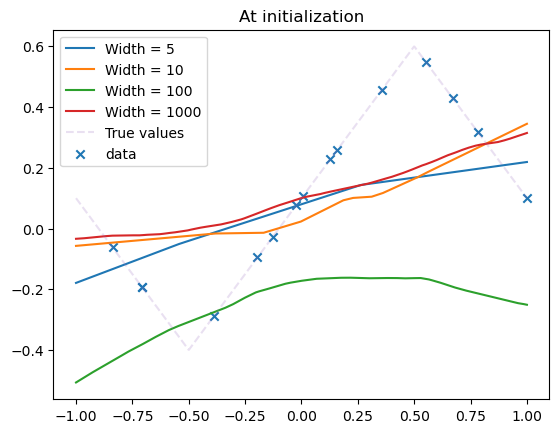

In [18]:
model_list = []

width_list = [5, 10, 100, 1000]

for width in width_list:
    model = MLPshallow(hidden_dim=width)
    model_list.append(model)
    plot_net(model, label=f"Width = {model.hidden_dim}")

plot_data(dataset)
plt.title("At initialization")
plt.legend()

all_losses = [[] for _ in width_list]
all_weights = []

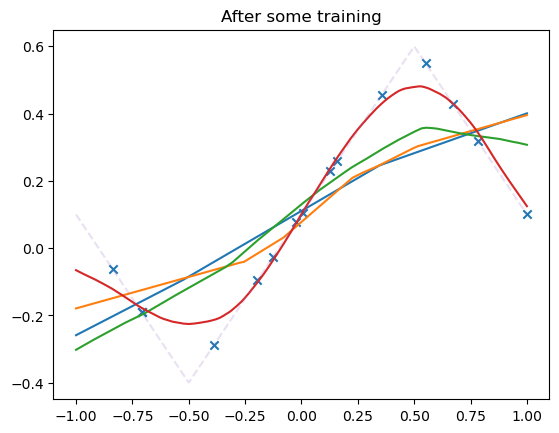

In [19]:
N_steps = 5000

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.001,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, label=f"Width = {model.hidden_dim}")

plot_data(dataset)
plt.title("After some training")

plt.show()

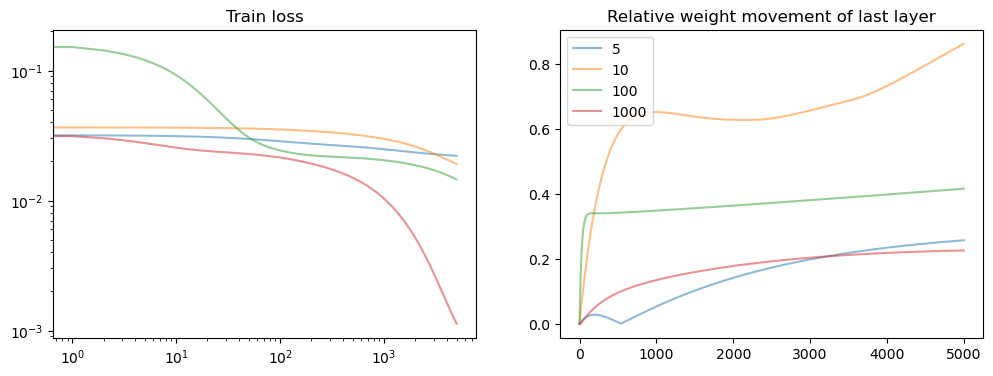

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5, label=f"{width_list[i]}")

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5, label=f"{model.hidden_dim}")

plt.legend()
plt.show()

## Bad initialization can you get you out of the Lazy regime


We simulate bad initialization by taking two steps of gradient descent from initialization.

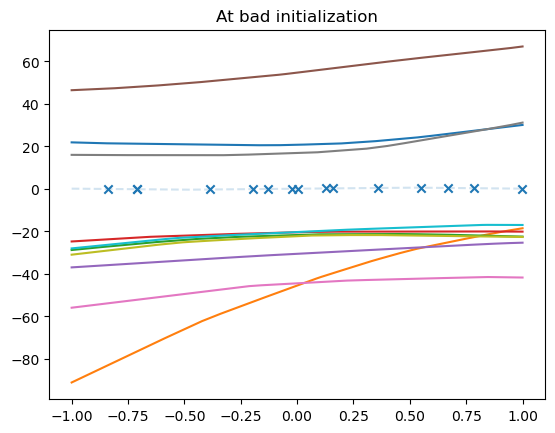

In [21]:
model_list = []
N_models = 10
for _ in range(N_models):
    model = MLPshallow(hidden_dim=100)
    model_list.append(model)
    train(
        model,
        dataset,
        N_steps=2,
        batch_size=30,
        lr=1,
        save_weights_every=-1,
    )
    plot_net(model)


plot_data(dataset)
plt.title("At bad initialization")

all_losses = [[] for _ in range(N_models)]
all_weights = []

-0.83795696 0.9992029


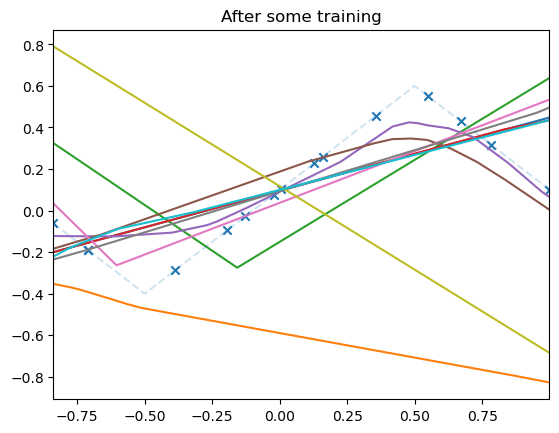

In [22]:
N_steps = 1000
xmin = np.min(dataset.inputs.detach().numpy())
xmax = np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=30,
        lr=0.001,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, xmin=xmin, xmax=xmax)

plot_data(dataset)
plt.title("After some training")

plt.show()

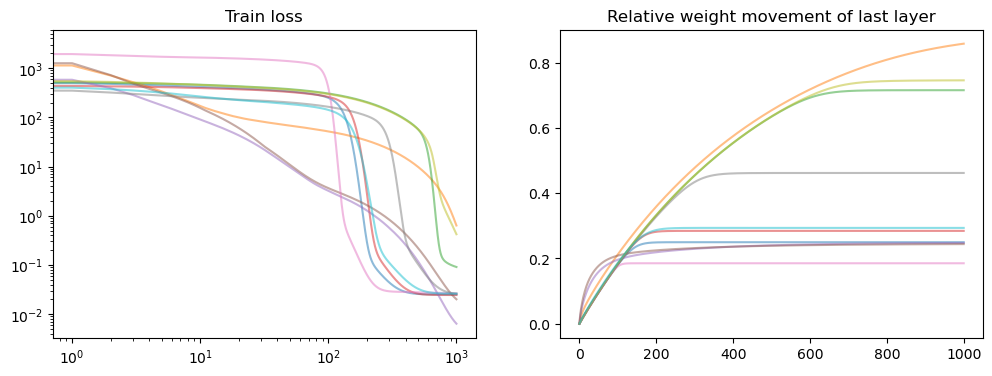

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=0.5)

axs[1].set_title("Relative weight movement of last layer")
for model in model_list:
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5)

plt.show()

# Linearizing an MLP

In [28]:
dtype = torch.float32


def mlp(x, a, b, c):
    x = x.reshape(-1, 1)  # (N,1)
    m = a.shape[0]

    a = a.reshape(1, m)  # (1,m)
    b = b.reshape(1, m)  # (1,m)
    c = c.reshape(1, m)  # (1,m)

    z = x * a + b  # (N,m)
    h = torch.relu(z)
    return (h * c).sum(dim=1)  # (N,)


def h0_and_J_at_init(x, a0, b0, c0):
    """
    Compute the initial output h0 and the Jacobian J of a 1-hidden-layer ReLU model.
    """
    # x: (N, 1) (also works if x is (N,))
    x = x.reshape(-1, 1)  # (N,1)
    m = a0.shape[0]

    a0 = a0.reshape(1, m)  # (1,m)
    b0 = b0.reshape(1, m)  # (1,m)
    c0 = c0.reshape(1, m)  # (1,m)

    z = x * a0 + b0  # (N,m)
    s = (z > 0).to(z.dtype)  # (N,m)
    relu = torch.relu(z)  # (N,m)

    h0 = (relu * c0).sum(dim=1)  # (N,)

    phi_a = (c0 * s) * x  # (N,m)
    phi_b = c0 * s  # (N,m)
    phi_c = relu  # (N,m)

    J = torch.cat([phi_a, phi_b, phi_c], dim=1)  # (N,3m)
    return h0, J

In [29]:
dataset = Data(n=32, xmin=-1, xmax=1, noise_level=0, type="middle")
x_train, y_train = dataset.next_batch(64)
y_train = y_train.squeeze(-1)
print(x_train.shape)

torch.Size([32, 1])


In [30]:
m = 5000
P = 3 * m

a0 = 0.7 * torch.randn(m)
b0 = 0.7 * torch.randn(m)
c0 = 0.7 * torch.randn(m)

w0 = torch.cat([a0, b0, c0], dim=0)  # (3K,)

a = a0.clone().detach().requires_grad_(True)
b = b0.clone().detach().requires_grad_(True)
c = c0.clone().detach().requires_grad_(True)

steps = 10000
losses_lin, losses_nl = [], []
dist_weights = []  # ||theta_nl(t) - theta_lin(t)||_2

In [31]:
# linearized model at init: f_lin(x; w) = f0(x) + J(x) (w - w0)

dw = torch.zeros(P, dtype=dtype, requires_grad=True)
f0_train, J_train = h0_and_J_at_init(x_train, a0, b0, c0)

lr = 1e-4


In [33]:
for t in range(steps):
    # linearized GD on dw
    pred_lin = f0_train + J_train @ dw
    loss_lin = torch.mean((pred_lin - y_train) ** 2)
    loss_lin.backward()
    with torch.no_grad():
        dw -= lr * dw.grad
        dw.grad.zero_()
    losses_lin.append(float(loss_lin.detach().cpu()))

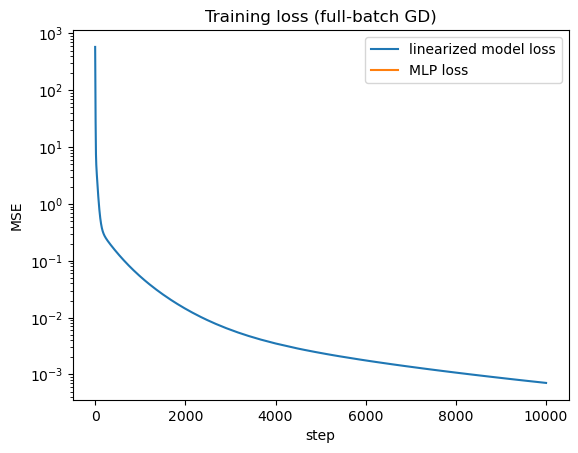

In [34]:
plt.plot(losses_lin, label="linearized model loss")
plt.plot(losses_nl, label="MLP loss")
plt.yscale("log")
plt.legend()
plt.title("Training loss (full-batch GD)")
plt.xlabel("step")
plt.ylabel("MSE")
plt.show()

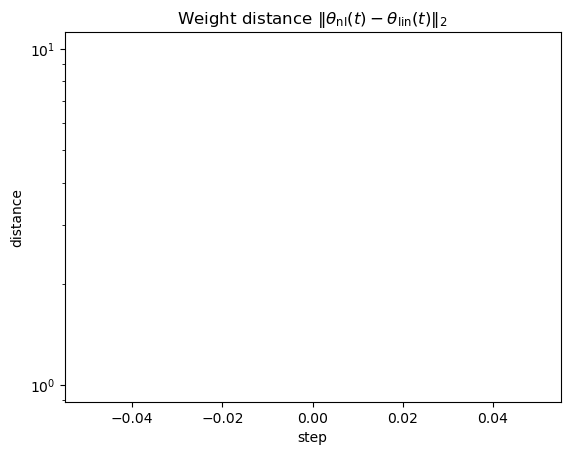

In [35]:
plt.plot(dist_weights)
plt.yscale("log")
plt.title(r"Weight distance $\|\theta_{\mathrm{nl}}(t)-\theta_{\mathrm{lin}}(t)\|_2$")
plt.xlabel("step")
plt.ylabel("distance")
plt.show()


# Scaling

Now we attempt to enter the lazy regime by scaling the model outputs. 

I did not manage to make a convincing case that we are in the lazy training regime. Can you? 

In [36]:
n_points = 10

dataset = Data(n=n_points, xmin=-1, xmax=1, noise_level=0, type="middle")

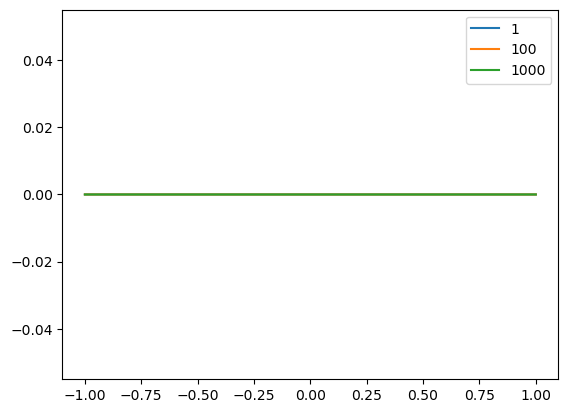

In [37]:
class ScaledModel(MLPdeep):
    """ "
    From a base network, creates a scaled copy with 0 initialization. Keeps a frozen copy of a base model.

    alpha: scaling factor
    """

    def __init__(self, base_model, alpha=1):
        super().__init__(hidden_dim=base_model.hidden_dim)

        self.alpha = alpha
        self.load_state_dict(base_model.state_dict())

        self.base_model = [
            base_model
        ]  # trick to hide from the other parameters dictionary. Probably not the proper way to do this...

    def forward(self, x):
        """
        Scales the output and subtracts the initial function
        """
        with torch.no_grad():
            base = self.base_model[0].forward(x).detach()
        return self.alpha * (super().forward(x) - base)


base_model = MLPdeep(hidden_dim=8)

alphas = [1, 100, 1000]  # , 2000, 10000]
model_list = []

for alpha in alphas:
    new_model = ScaledModel(base_model, alpha=alpha)
    new_model.load_state_dict(base_model.state_dict())
    model_list.append(new_model)

    plot_net(new_model, label=f"{alpha}")

all_losses = [[] for _ in range(len(model_list))]

plt.legend()
plt.show()

In [38]:
# train a single model

# i = 0
# train(model_list[i],
#     dataset,
#     N_steps=10000,
#     batch_size=n_points,
#     lr=.1 / alphas[i]**2,
#     save_weights_every=1,
#     )

# plot_data(dataset)
# plt.legend()
# plt.title('After some training')


# for i, model in enumerate(model_list):
#     plot_net(model, xmin=xmin, xmax=xmax, label=f'alpha = {alphas[i]}')

-1 1


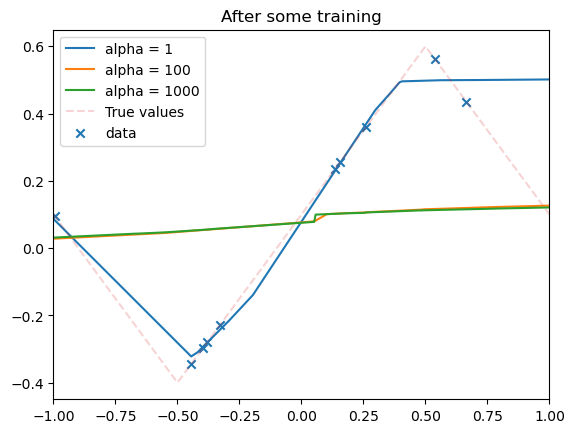

In [39]:
N_steps = 10000
xmin = -1  # np.min(dataset.inputs.detach().numpy())
xmax = 1  # np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(
        model,
        dataset,
        N_steps=N_steps,
        batch_size=n_points,
        lr=0.01 / alphas[i] ** 2,
        save_weights_every=1,
    )
    all_losses[i] += losses
    plot_net(model, xmin=xmin, xmax=xmax, label=f"alpha = {alphas[i]}")

plot_data(dataset)
plt.legend()
plt.title("After some training")

plt.show()

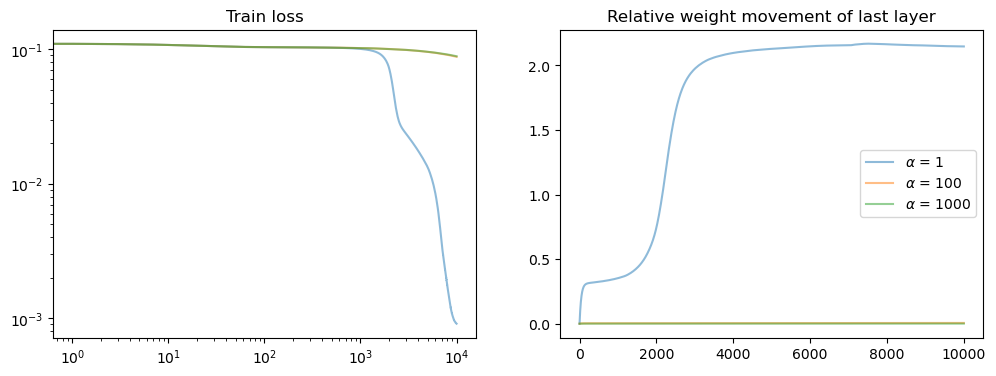

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Train loss")
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)
    losses = np.array(losses)  # / alphas[i] ** 2
    axs[0].loglog(points, losses[points], alpha=0.5, label=f"{alphas[i]}")

axs[1].set_title("Relative weight movement of last layer")
for i, model in enumerate(model_list):
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(
        all_weights1 - all_weights1[0], axis=1
    ) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=0.5, label=rf"$\alpha$ = {alphas[i]}")

plt.legend()
plt.show()

## 5 - The effect of scaling on a 1D model 

**Question** Explain the piece of code below.



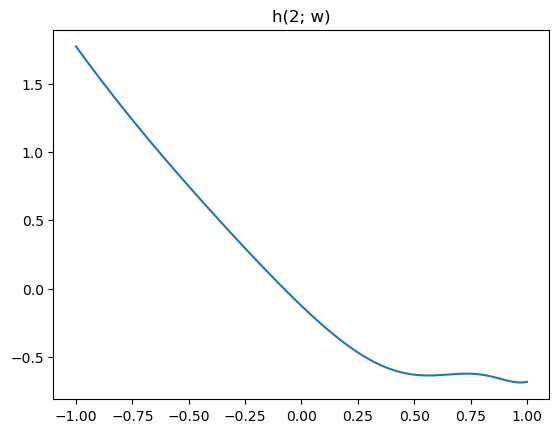

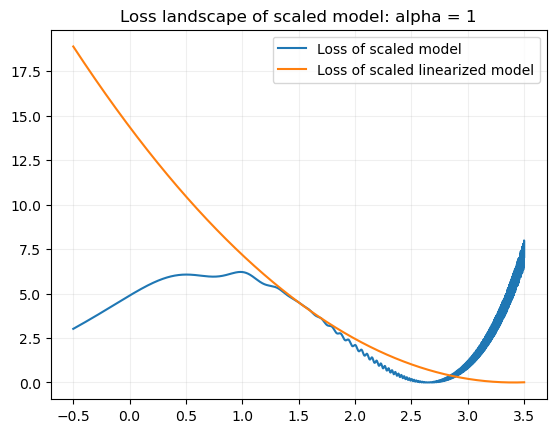

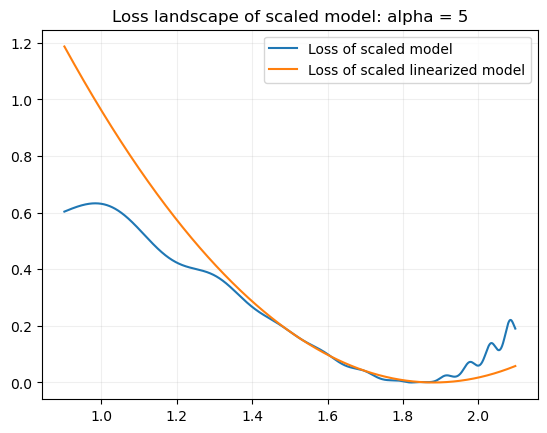

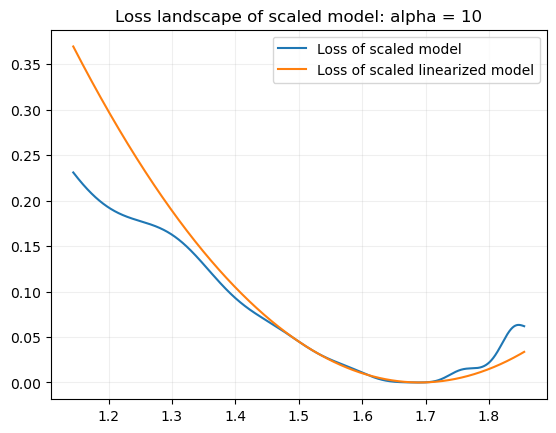

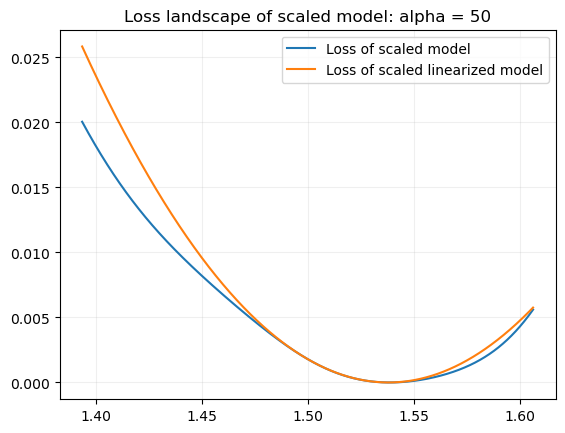

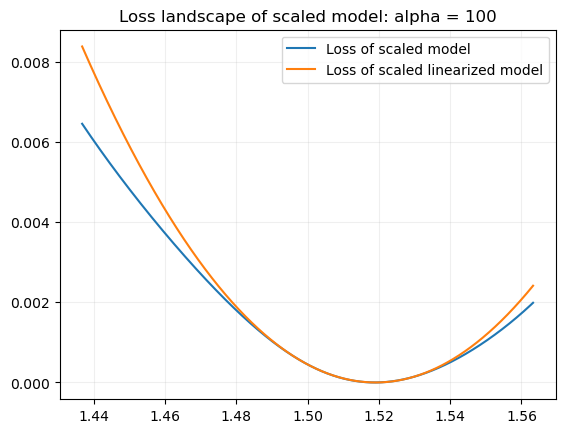

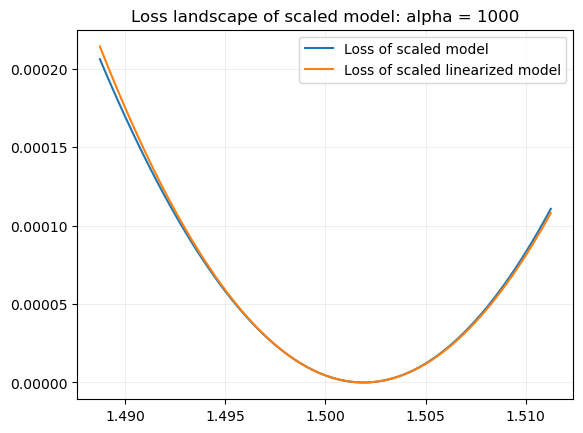

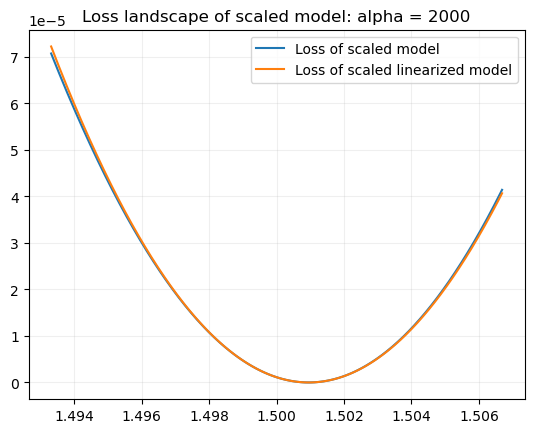

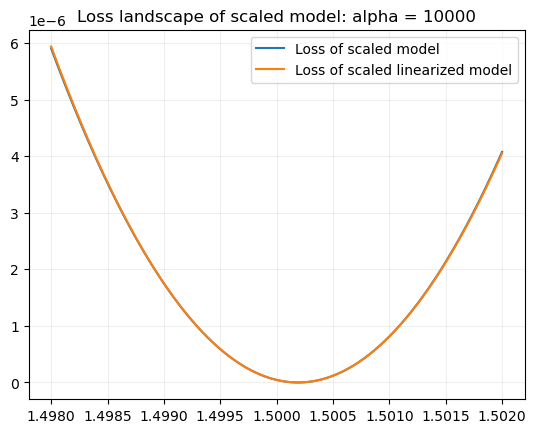

In [41]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5


def f(x, w):
    return (
        w * x / 2 + np.log(1 + w**2) * x / 5 + 0.1 * np.sin(np.exp(2 * w))
    )  # np.exp(0.1*w))


def h(x, w, w_0=0.4):
    return f(x, w) * (w - w_0)


def linh(x, w, w_0=0.4):
    return f(x, w_0) * (w - w_0)


xys = [(1.5, 3)]


def l(w, alpha):
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2


def linl(w, alpha):
    return (
        np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2
    )


alphas = [1, 5, 10, 50, 100, 1000, 2000, 10000]

ws = np.linspace(-1, 1, 100)
plt.title("h(2; w)")
plt.plot(ws, [h(2, w, w_0=w_0) for w in ws])
plt.show()

for alpha in alphas:
    delta = 2 / alpha ** (3 / 4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f"Loss landscape of scaled model: alpha = {alpha}")
    plt.plot(ws, [l(w, alpha) for w in ws], label="Loss of scaled model")
    plt.plot(ws, [linl(w, alpha) for w in ws], label="Loss of scaled linearized model")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

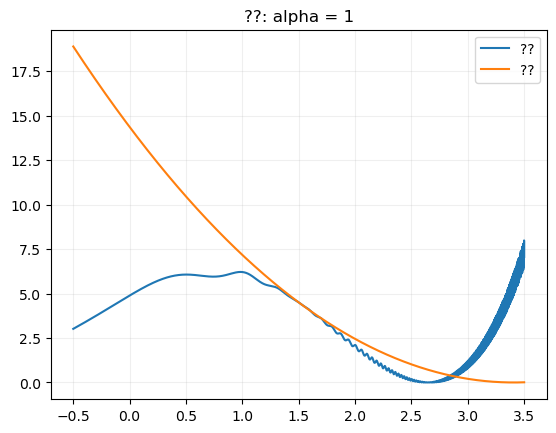

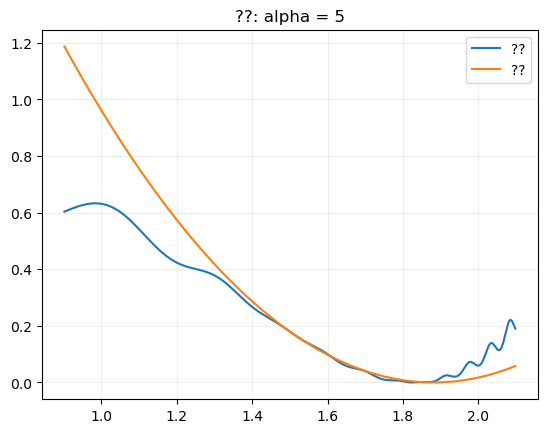

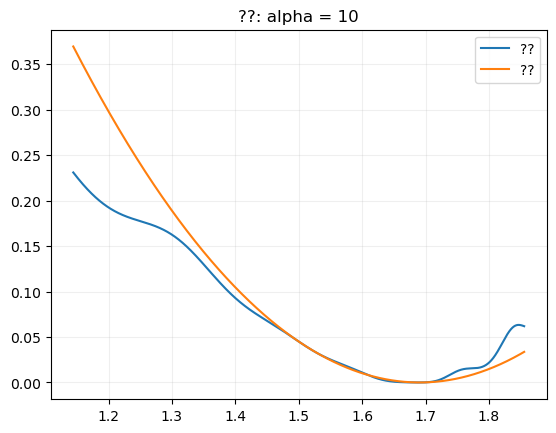

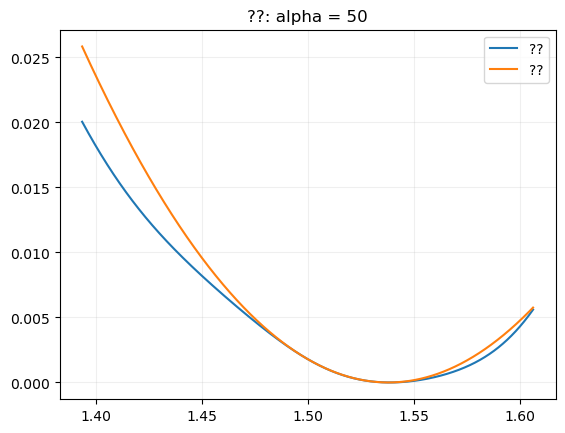

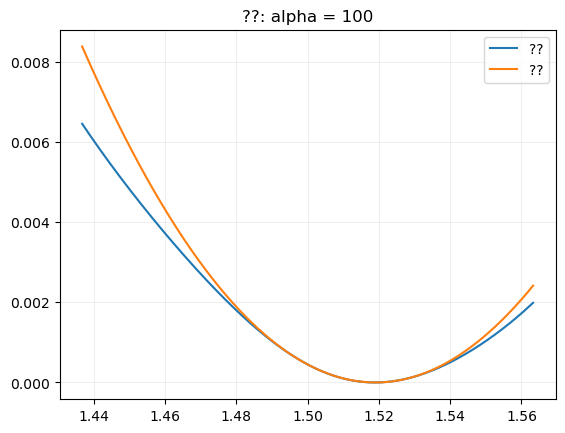

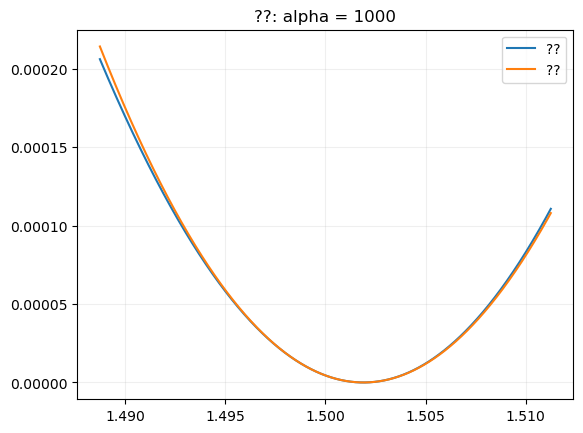

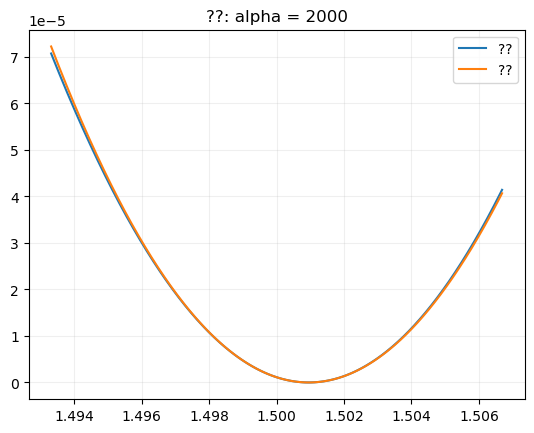

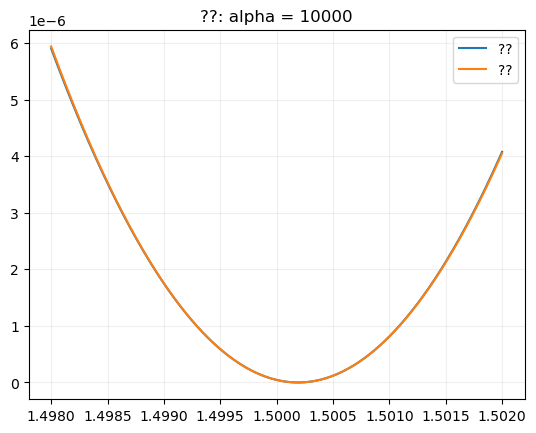

In [42]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5


def f(x, w):
    return w * x / 2 + np.log(1 + w**2) * x / 5 + 0.1 * np.sin(np.exp(2 * w))


def h(x, w, w_0=0.4):
    return f(x, w) * (w - w_0)


def linh(x, w, w_0=0.4):
    return f(x, w_0) * (w - w_0)


xys = [(1.5, 3)]


def l(w, alpha):
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2


def linl(w, alpha):
    return (
        np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha**2
    )


alphas = [1, 5, 10, 50, 100, 1000, 2000, 10000]

for alpha in alphas:
    delta = 2 / alpha ** (3 / 4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f"??: alpha = {alpha}")
    plt.plot(ws, [l(w, alpha) for w in ws], label="??")
    plt.plot(ws, [linl(w, alpha) for w in ws], label="??")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()